试题说明

任务说明
基于Caltech数据集的图像分类，Caltech101包含102个类，每种类别大约40到800个图像，训练集总计7999图像。本次试题需要图片为输入，通过课程学习的分类方法（支持向量机、深度神经网络、卷积神经网络等）从中识别该图像属于哪一个类别。
[](img/2022-06-18-13-58-06.png)

数据说明
images下存储所有的训练+测试图像，trian.txt中存储用于训练图像路径和对应标注，图片路径+\t+标签，test.txt中存储测试图像。
[](img/2022-06-18-13-58-35.png)

提交答案
考试提交，需要提交模型代码项目版本和结果文件。结果文件为TXT文件格式，命名为result.txt，文件内的字段需要按照指定格式写入。
结果文件要求：
1,每一行为： 图像名\t标签  101_0073.jpg\t13
2.输出结果应检查是否为1145行数据，否则成绩无效。
3.输出结果文件命名为result.txt，一行一个数据，样例如下：
[](img/2022-06-18-13-58-48.png)
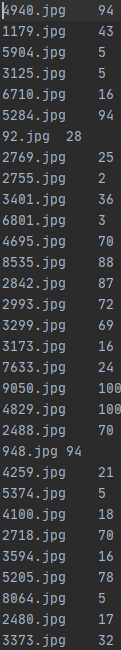
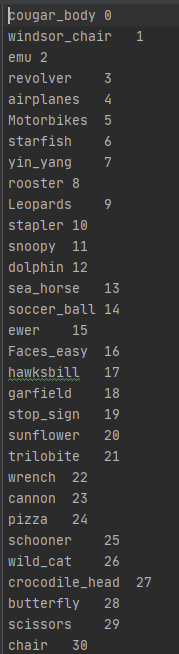
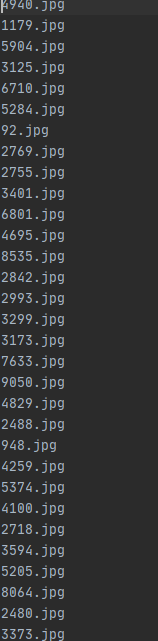

### 0.导包

In [11]:

import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
from PIL.Image import Resampling
import matplotlib.pyplot as plt
import paddle
from paddle.io import Dataset
import paddle.nn as nn
from paddle.nn import Conv2D, MaxPool2D, AdaptiveAvgPool2D, Linear, ReLU, BatchNorm2D
import paddle.nn.functional as F

## 1.数据准备 Data Preparation

### 解压数据集

In [12]:
import os,zipfile
def unzip_data(src_path, dest_path):
    # 解压文件
    if not os.path.isdir(dest_path):
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=dest_path)
        z.close()
        print("解压成功")
    else:
        print("已经解压或无法解压")

# unzip_data(src_path="data/data146107/dataset.zip", dest_path="data/data146107/dataset")

### 将图片和标签转为dataLoader

In [13]:
class Reader(Dataset):
    def __init__(self,data_path="data/images",mode='train'):
        """数据读取器

        Args:
            data_path (string): 数据集所在目录的路径,这个目录中包含train.txt等文件
            mode (str, optional): 训练train或测试test. Defaults to 'train'.
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []
        self.file_names = []
        
        if mode == 'train':
            # 训练模式 则需要根据train.txt文件内容来添加训练数据集的路径和标签
            with open(os.path.join(self.data_path,"train.txt"),mode = "r",encoding="utf-8") as f:
                self.info = f.readlines() 
            for img_info in self.info:
                img_filename,label = img_info.strip().split("\t")
                self.img_paths.append(os.path.join(self.data_path,img_filename))
                self.labels.append(int(label))
        elif mode == 'test':
            # 测试模式 test.txt文件内容来添加训练数据集的路径和标签
            with open(os.path.join(self.data_path,"test.txt"),mode = "r",encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_filename = img_info.strip().split("\n")[0]
                self.file_names.append(img_filename)
                self.img_paths.append(os.path.join(self.data_path,img_filename))
                self.labels.append(999)  
        else:
            assert("mode Error")
    
    def __getitem__(self,index):
        """根据索引获取数据,预处理

        Args:
            index (int): 索引
        """
        img_path = self.img_paths[index]
        img = Image.open(img_path) # Load文件
        
        # Mode转换
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        
        # size调整 ,采用双线性算子
        img = img.resize((224,224),Resampling.BILINEAR)
        
        # 转换成浮点型ndarray
        img = np.array(img, dtype = 'float32')
        img = img.transpose((2, 0, 1)) / 255 #归一化
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label
    
    def print_sample(self, index: int = 0):
        print("Path:", self.img_paths[index], "\tLabel:", self.labels[index])

    def __len__(self):
        return len(self.img_paths)
# test_dataset = Reader()
test_dataset = Reader(mode="test")               

In [14]:
# 使用paddle的框架实例化数据Loader
train_dataset = Reader()
train_loader = paddle.io.DataLoader(train_dataset,batch_size=16,shuffle=False)

test_dataset = Reader(mode="test")   
test_loader = paddle.io.DataLoader(test_dataset,batch_size=1,shuffle=False)

## ResNet训练与预测

In [15]:
from paddle.vision.models import resnet50
model = resnet50(pretrained=True,num_classes = 102)
model = paddle.Model(model)
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),
                    paddle.nn.CrossEntropyLoss(),
                    paddle.metric.Accuracy())
# model.fit(train_dataset,epochs=20,batch_size=64,verbose=2)

    

INFO 2022-06-18 17:05:21,361 download.py:117] unique_endpoints {''}
INFO 2022-06-18 17:05:21,361 download.py:269] File /Users/zane/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...
INFO 2022-06-18 17:05:21,706 download.py:154] Found /Users/zane/.cache/paddle/hapi/weights/resnet50.pdparams
/Users/zane/miniforge3/envs/pd/lib/python3.9/site-packages/paddle/fluid/dygraph/layers.py:1483: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 1000], but the expected shape is [2048, 102].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/Users/zane/miniforge3/envs/pd/lib/python3.9/site-packages/paddle/fluid/dygraph/layers.py:1483: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [102].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [23]:
result = []
for i in test_loader:
    y = paddle.to_tensor(model.predict_batch(i[0]))
    for j in y:
        a = paddle.argmax(j,axis=1)
        result.append(int(a))

/Users/zane/miniforge3/envs/pd/lib/python3.9/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


## 3.写入结果

In [26]:
with open("data/images/result.txt","w") as f:
    for i in range(len(test_dataset.file_names)):
        f.write(test_dataset.file_names[i]+"\t"+str(result[i])+"\n")